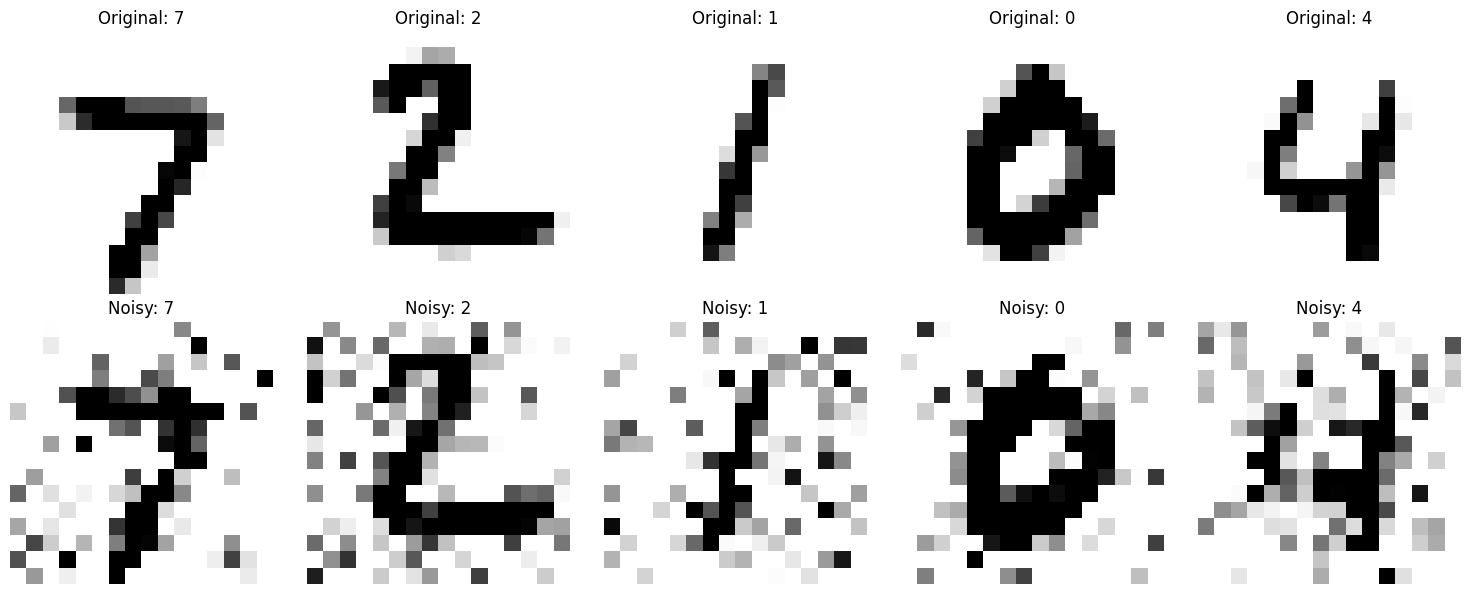

In [21]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

def add_noise(image, noise_factor=0.5):
    """Adds Gaussian noise to the image with a smoother distribution."""
    # Generate Gaussian noise with mean 0 and standard deviation 1
    noise = torch.randn(image.size())
    
    # Scale the noise by the noise factor
    noise = noise * noise_factor
    
    # Normalize the noise to be centered around 0.5 (mid-gray) with reduced intensity
    noisy_image = image + noise
    
    # Clip values to ensure the image stays in the range [0, 1]
    return torch.clamp(noisy_image, 0., 1.)

class NoisyMNISTDataset(Dataset):
    def __init__(self, mnist_dataset, noise_factor=0.5):
        self.mnist_dataset = mnist_dataset
        self.noise_factor = noise_factor

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        noisy_image = add_noise(image, self.noise_factor)
        return noisy_image, label

def visualize_noisy_mnist(noise_factor=0.5, num_samples=5):
    """Visualizes a few samples of noisy MNIST images."""
    # Load original MNIST dataset
    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: 1 - x)  # Invert the image to black digits on white background
    ])
    mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)
    
    # Create NoisyMNISTDataset
    noisy_mnist_dataset = NoisyMNISTDataset(mnist_test, noise_factor)
    
    # Create a figure
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    for i in range(num_samples):
        # Get a sample from the original MNIST dataset
        original_image, label = mnist_test[i]
        
        # Get the corresponding noisy image
        noisy_image, _ = noisy_mnist_dataset[i]
        
        # Display original image
        axes[0, i].imshow(original_image.squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[0, i].set_title(f"Original: {label}")
        axes[0, i].axis('off')
        
        # Display noisy image
        axes[1, i].imshow(noisy_image.squeeze(), cmap='gray', vmin=0, vmax=1)
        axes[1, i].set_title(f"Noisy: {label}")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_noisy_mnist(noise_factor=0.7)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, datasets, transforms
from tqdm import tqdm
import os
import zipfile
from PIL import Image

# Function to add noise
def add_noise(image, noise_factor=0.5):
    noise = noise_factor * torch.randn(image.size())
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0., 1.)

# NoisyMNISTDataset class
class NoisyMNISTDataset(Dataset):
    def __init__(self, mnist_dataset, noise_factor=0.5):
        self.mnist_dataset = mnist_dataset
        self.noise_factor = noise_factor

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        noisy_image = add_noise(image, self.noise_factor)
        return noisy_image, label

# Load experimental data
def load_all_experimental_data(test_digits_folder):
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []
    participant_data = {}

    transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    for filename in os.listdir(test_digits_folder):
        if filename.endswith('.zip') and filename.startswith('experiment_results_participant'):
            participant_number = int(filename.split('participant')[1].split('.')[0])
            zip_filepath = os.path.join(test_digits_folder, filename)

            participant_train_images = []
            participant_train_labels = []
            participant_test_images = []
            participant_test_labels = []

            with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
                for img_filename in zip_ref.namelist():
                    if img_filename.endswith('.png'):
                        with zip_ref.open(img_filename) as file:
                            img = Image.open(file).convert('L')
                            img_tensor = transform(img)
                            
                            digit = int(img_filename.split('_')[0])
                            
                            if 'composite' in img_filename:
                                test_images.append(img_tensor)
                                test_labels.append(digit)
                                participant_test_images.append(img_tensor)
                                participant_test_labels.append(digit)
                            else:
                                train_images.append(img_tensor)
                                train_labels.append(digit)
                                participant_train_images.append(img_tensor)
                                participant_train_labels.append(digit)

            participant_data[participant_number] = {
                'train': (torch.stack(participant_train_images), torch.tensor(participant_train_labels)),
                'test': (torch.stack(participant_test_images), torch.tensor(participant_test_labels))
            }

    return (torch.stack(train_images), torch.tensor(train_labels), 
            torch.stack(test_images), torch.tensor(test_labels),
            participant_data)

# Function to invert the MNIST images (black digits on white background)
def invert_image(image):
    return 1 - image

# Load MNIST datasets
def load_mnist_datasets():
    # Replace the lambda function with a regular function
    mnist_transform = transforms.Compose([
        transforms.Resize((16, 16)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(invert_image)  # Use invert_image function instead of lambda
    ])
    
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=mnist_transform)
    
    noisy_mnist_train = NoisyMNISTDataset(mnist_train, noise_factor=0.7)
    noisy_mnist_test = NoisyMNISTDataset(mnist_test, noise_factor=0.7)
    
    return mnist_train, mnist_test, noisy_mnist_train, noisy_mnist_test

# Create the ResNet50 model
def create_resnet50_model():
    model = models.resnet50(pretrained=True)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

# Training function
def train_model(model, train_dataloaders, val_dataloaders, num_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        
        for phase, dataloader in train_dataloaders.items():
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in tqdm(dataloader, desc=f"Training on {phase}"):
                inputs, labels = inputs.to(device), labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
            
            epoch_loss = running_loss / total
            epoch_acc = correct / total
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for phase, dataloader in val_dataloaders.items():
                for inputs, labels in tqdm(dataloader, desc=f"Validating on {phase}"):
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    val_correct += (preds == labels).sum().item()
                    val_total += labels.size(0)
                    
                val_epoch_loss = val_loss / val_total
                val_epoch_acc = val_correct / val_total
                print(f"Validation ({phase}) Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}")
        
        scheduler.step()
    # Save the model after training
    torch.save(model.state_dict(), 'resnet50_mnist_experiment.pth')
    print("Model saved as resnet50_mnist_experiment.pth")
    print("Training completed.")

def main():
    # Load MNIST datasets
    mnist_train, mnist_test, noisy_mnist_train, noisy_mnist_test = load_mnist_datasets()

    # Load experimental data
    exp_train_images, exp_train_labels, exp_test_images, exp_test_labels, participant_data = load_all_experimental_data('test_digits')
    
    # Create DataLoaders for training and validation
    train_dataloaders = {
        "mnist_inverted": DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=0),
        "mnist_noisy": DataLoader(noisy_mnist_train, batch_size=64, shuffle=True, num_workers=0),
        "experimental": DataLoader(TensorDataset(exp_train_images, exp_train_labels), batch_size=64, shuffle=True, num_workers=0)
    }
    
    val_dataloaders = {
        "mnist_inverted": DataLoader(mnist_test, batch_size=64, shuffle=False, num_workers=0),
        "mnist_noisy": DataLoader(noisy_mnist_test, batch_size=64, shuffle=False, num_workers=0),
        "experimental": DataLoader(TensorDataset(exp_test_images, exp_test_labels), batch_size=64, shuffle=False, num_workers=0)
    }
    
    # Create the model
    model = create_resnet50_model()

    # Train the model
    train_model(model, train_dataloaders, val_dataloaders, num_epochs=50)

if __name__ == "__main__":
    main()

Epoch 1/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:46<00:00, 20.05it/s]


mnist_inverted Loss: 0.3056 Acc: 0.9086


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.82it/s]


mnist_noisy Loss: 0.3932 Acc: 0.8818


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.57it/s]


experimental Loss: 2.5536 Acc: 0.1007


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 46.15it/s]


Validation (mnist_inverted) Loss: 2.4828 Acc: 0.0950


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.30it/s]


Validation (mnist_noisy) Loss: 2.4774 Acc: 0.0962


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 60.35it/s]


Validation (experimental) Loss: 2.4788 Acc: 0.0963
Epoch 2/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.61it/s]


mnist_inverted Loss: 0.6747 Acc: 0.7700


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.89it/s]


mnist_noisy Loss: 0.3786 Acc: 0.8805


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.68it/s]


experimental Loss: 2.4821 Acc: 0.1066


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.04it/s]


Validation (mnist_inverted) Loss: 2.1876 Acc: 0.2750


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.61it/s]


Validation (mnist_noisy) Loss: 2.2314 Acc: 0.2457


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 88.56it/s]


Validation (experimental) Loss: 2.2315 Acc: 0.2451
Epoch 3/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.69it/s]


mnist_inverted Loss: 0.1709 Acc: 0.9494


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.57it/s]


mnist_noisy Loss: 0.2979 Acc: 0.9101


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 25.82it/s]


experimental Loss: 2.4280 Acc: 0.1043


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.02it/s]


Validation (mnist_inverted) Loss: 2.2032 Acc: 0.2507


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.58it/s]


Validation (mnist_noisy) Loss: 2.2324 Acc: 0.2188


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 63.70it/s]


Validation (experimental) Loss: 2.2325 Acc: 0.2185
Epoch 4/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:46<00:00, 20.05it/s]


mnist_inverted Loss: 0.1910 Acc: 0.9493


Training on mnist_noisy: 100%|██████████| 938/938 [00:48<00:00, 19.29it/s]


mnist_noisy Loss: 0.2096 Acc: 0.9329


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 25.97it/s]


experimental Loss: 2.4100 Acc: 0.1083


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.12it/s]


Validation (mnist_inverted) Loss: 2.1704 Acc: 0.3307


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.74it/s]


Validation (mnist_noisy) Loss: 2.2013 Acc: 0.2866


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 80.05it/s]


Validation (experimental) Loss: 2.2016 Acc: 0.2863
Epoch 5/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:46<00:00, 20.08it/s]


mnist_inverted Loss: 0.1555 Acc: 0.9563


Training on mnist_noisy: 100%|██████████| 938/938 [00:48<00:00, 19.48it/s]


mnist_noisy Loss: 0.1899 Acc: 0.9403


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 25.66it/s]


experimental Loss: 2.3770 Acc: 0.1123


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 46.29it/s]


Validation (mnist_inverted) Loss: 2.1905 Acc: 0.2259


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.20it/s]


Validation (mnist_noisy) Loss: 2.2170 Acc: 0.2042


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 101.53it/s]


Validation (experimental) Loss: 2.2185 Acc: 0.2042
Epoch 6/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:46<00:00, 20.08it/s]


mnist_inverted Loss: 0.1261 Acc: 0.9672


Training on mnist_noisy: 100%|██████████| 938/938 [00:48<00:00, 19.46it/s]


mnist_noisy Loss: 0.1735 Acc: 0.9457


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.10it/s]


experimental Loss: 2.3816 Acc: 0.1173


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 46.01it/s]


Validation (mnist_inverted) Loss: 2.2117 Acc: 0.1818


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.05it/s]


Validation (mnist_noisy) Loss: 2.3052 Acc: 0.1579


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 78.88it/s]


Validation (experimental) Loss: 2.3064 Acc: 0.1588
Epoch 7/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:46<00:00, 20.22it/s]


mnist_inverted Loss: 0.1079 Acc: 0.9735


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.58it/s]


mnist_noisy Loss: 0.1582 Acc: 0.9490


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 25.57it/s]


experimental Loss: 2.3740 Acc: 0.1182


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.97it/s]


Validation (mnist_inverted) Loss: 1.9879 Acc: 0.2834


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.19it/s]


Validation (mnist_noisy) Loss: 2.1071 Acc: 0.2641


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 77.27it/s]


Validation (experimental) Loss: 2.1072 Acc: 0.2647
Epoch 8/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:46<00:00, 20.23it/s]


mnist_inverted Loss: 0.1014 Acc: 0.9784


Training on mnist_noisy: 100%|██████████| 938/938 [00:48<00:00, 19.42it/s]


mnist_noisy Loss: 0.1534 Acc: 0.9516


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 25.84it/s]


experimental Loss: 2.3698 Acc: 0.1172


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 46.67it/s]


Validation (mnist_inverted) Loss: 2.1846 Acc: 0.3026


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.55it/s]


Validation (mnist_noisy) Loss: 2.2057 Acc: 0.2611


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 74.53it/s]


Validation (experimental) Loss: 2.2050 Acc: 0.2623
Epoch 9/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:46<00:00, 20.24it/s]


mnist_inverted Loss: 0.0851 Acc: 0.9811


Training on mnist_noisy: 100%|██████████| 938/938 [00:48<00:00, 19.45it/s]


mnist_noisy Loss: 0.1622 Acc: 0.9499


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 25.85it/s]


experimental Loss: 2.3631 Acc: 0.1210


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 46.85it/s]


Validation (mnist_inverted) Loss: 2.2091 Acc: 0.4646


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.58it/s]


Validation (mnist_noisy) Loss: 2.2165 Acc: 0.3389


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 69.32it/s]


Validation (experimental) Loss: 2.2154 Acc: 0.3390
Epoch 10/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:46<00:00, 20.11it/s]


mnist_inverted Loss: 0.0788 Acc: 0.9841


Training on mnist_noisy: 100%|██████████| 938/938 [00:48<00:00, 19.39it/s]


mnist_noisy Loss: 0.1385 Acc: 0.9554


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.38it/s]


experimental Loss: 2.3486 Acc: 0.1266


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 45.73it/s]


Validation (mnist_inverted) Loss: 3.7427 Acc: 0.4954


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.70it/s]


Validation (mnist_noisy) Loss: 2.9970 Acc: 0.3427


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 91.37it/s]


Validation (experimental) Loss: 2.9898 Acc: 0.3435
Epoch 11/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:46<00:00, 20.23it/s]


mnist_inverted Loss: 0.1542 Acc: 0.9823


Training on mnist_noisy: 100%|██████████| 938/938 [00:48<00:00, 19.40it/s]


mnist_noisy Loss: 0.1357 Acc: 0.9580


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.03it/s]


experimental Loss: 2.3102 Acc: 0.1462


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.79it/s]


Validation (mnist_inverted) Loss: 1.0684 Acc: 0.7896


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.82it/s]


Validation (mnist_noisy) Loss: 1.3268 Acc: 0.7079


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 87.78it/s]


Validation (experimental) Loss: 1.3301 Acc: 0.7068
Epoch 12/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:46<00:00, 20.21it/s]


mnist_inverted Loss: 0.0379 Acc: 0.9913


Training on mnist_noisy: 100%|██████████| 938/938 [00:48<00:00, 19.34it/s]


mnist_noisy Loss: 0.1243 Acc: 0.9605


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.09it/s]


experimental Loss: 2.2709 Acc: 0.1545


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 46.76it/s]


Validation (mnist_inverted) Loss: 1.2015 Acc: 0.8081


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.16it/s]


Validation (mnist_noisy) Loss: 1.3945 Acc: 0.7194


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 101.61it/s]


Validation (experimental) Loss: 1.3974 Acc: 0.7179
Epoch 13/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:46<00:00, 20.16it/s]


mnist_inverted Loss: 0.0257 Acc: 0.9927


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.69it/s]


mnist_noisy Loss: 0.1136 Acc: 0.9647


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.04it/s]


experimental Loss: 2.2544 Acc: 0.1596


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.25it/s]


Validation (mnist_inverted) Loss: 1.3572 Acc: 0.7668


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.06it/s]


Validation (mnist_noisy) Loss: 1.4582 Acc: 0.6623


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 86.49it/s]


Validation (experimental) Loss: 1.4602 Acc: 0.6611
Epoch 14/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:46<00:00, 20.37it/s]


mnist_inverted Loss: 0.0221 Acc: 0.9939


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.59it/s]


mnist_noisy Loss: 0.1114 Acc: 0.9647


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.70it/s]


experimental Loss: 2.2419 Acc: 0.1670


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.41it/s]


Validation (mnist_inverted) Loss: 0.9247 Acc: 0.8072


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.85it/s]


Validation (mnist_noisy) Loss: 1.2335 Acc: 0.7003


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 85.77it/s]


Validation (experimental) Loss: 1.2373 Acc: 0.6985
Epoch 15/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.62it/s]


mnist_inverted Loss: 0.0193 Acc: 0.9945


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.72it/s]


mnist_noisy Loss: 0.1059 Acc: 0.9659


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 25.79it/s]


experimental Loss: 2.2327 Acc: 0.1731


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.17it/s]


Validation (mnist_inverted) Loss: 0.9589 Acc: 0.7976


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.99it/s]


Validation (mnist_noisy) Loss: 1.2223 Acc: 0.6748


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 66.80it/s]


Validation (experimental) Loss: 1.2256 Acc: 0.6731
Epoch 16/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.49it/s]


mnist_inverted Loss: 0.0171 Acc: 0.9949


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.73it/s]


mnist_noisy Loss: 0.1017 Acc: 0.9676


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.42it/s]


experimental Loss: 2.2224 Acc: 0.1782


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.99it/s]


Validation (mnist_inverted) Loss: 0.8787 Acc: 0.7917


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.94it/s]


Validation (mnist_noisy) Loss: 1.1526 Acc: 0.6787


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 99.66it/s]


Validation (experimental) Loss: 1.1563 Acc: 0.6772
Epoch 17/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.50it/s]


mnist_inverted Loss: 0.0155 Acc: 0.9955


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.72it/s]


mnist_noisy Loss: 0.1002 Acc: 0.9674


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.92it/s]


experimental Loss: 2.2110 Acc: 0.1848


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.00it/s]


Validation (mnist_inverted) Loss: 0.8634 Acc: 0.7784


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.18it/s]


Validation (mnist_noisy) Loss: 1.1816 Acc: 0.6337


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 77.48it/s]


Validation (experimental) Loss: 1.1851 Acc: 0.6320
Epoch 18/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:46<00:00, 20.37it/s]


mnist_inverted Loss: 0.0139 Acc: 0.9959


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.63it/s]


mnist_noisy Loss: 0.0965 Acc: 0.9688


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 25.97it/s]


experimental Loss: 2.2002 Acc: 0.1931


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.95it/s]


Validation (mnist_inverted) Loss: 0.8331 Acc: 0.8119


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.47it/s]


Validation (mnist_noisy) Loss: 1.1273 Acc: 0.6773


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 60.12it/s]


Validation (experimental) Loss: 1.1309 Acc: 0.6756
Epoch 19/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:46<00:00, 20.25it/s]


mnist_inverted Loss: 0.0133 Acc: 0.9965


Training on mnist_noisy: 100%|██████████| 938/938 [00:48<00:00, 19.46it/s]


mnist_noisy Loss: 0.0962 Acc: 0.9686


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.09it/s]


experimental Loss: 2.1891 Acc: 0.1979


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.34it/s]


Validation (mnist_inverted) Loss: 0.7912 Acc: 0.7922


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.28it/s]


Validation (mnist_noisy) Loss: 1.1075 Acc: 0.6567


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 110.01it/s]


Validation (experimental) Loss: 1.1114 Acc: 0.6554
Epoch 20/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:46<00:00, 20.17it/s]


mnist_inverted Loss: 0.0119 Acc: 0.9969


Training on mnist_noisy: 100%|██████████| 938/938 [00:48<00:00, 19.54it/s]


mnist_noisy Loss: 0.0939 Acc: 0.9696


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 25.84it/s]


experimental Loss: 2.1702 Acc: 0.2082


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.33it/s]


Validation (mnist_inverted) Loss: 0.8736 Acc: 0.7511


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.67it/s]


Validation (mnist_noisy) Loss: 1.1368 Acc: 0.6380


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 81.34it/s]


Validation (experimental) Loss: 1.1405 Acc: 0.6364
Epoch 21/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.50it/s]


mnist_inverted Loss: 0.0122 Acc: 0.9970


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.93it/s]


mnist_noisy Loss: 0.0909 Acc: 0.9708


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.82it/s]


experimental Loss: 2.1387 Acc: 0.2234


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.04it/s]


Validation (mnist_inverted) Loss: 0.9507 Acc: 0.7253


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.21it/s]


Validation (mnist_noisy) Loss: 1.1547 Acc: 0.6240


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 96.32it/s]


Validation (experimental) Loss: 1.1581 Acc: 0.6225
Epoch 22/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.68it/s]


mnist_inverted Loss: 0.0114 Acc: 0.9971


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 19.98it/s]


mnist_noisy Loss: 0.0896 Acc: 0.9707


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.77it/s]


experimental Loss: 2.1330 Acc: 0.2254


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.56it/s]


Validation (mnist_inverted) Loss: 0.9800 Acc: 0.7118


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.70it/s]


Validation (mnist_noisy) Loss: 1.1679 Acc: 0.6192


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 106.54it/s]


Validation (experimental) Loss: 1.1713 Acc: 0.6180
Epoch 23/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.83it/s]


mnist_inverted Loss: 0.0111 Acc: 0.9969


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.88it/s]


mnist_noisy Loss: 0.0918 Acc: 0.9693


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 25.97it/s]


experimental Loss: 2.1299 Acc: 0.2301


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.81it/s]


Validation (mnist_inverted) Loss: 1.3479 Acc: 0.6859


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.53it/s]


Validation (mnist_noisy) Loss: 1.3413 Acc: 0.6095


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 80.08it/s]


Validation (experimental) Loss: 1.3434 Acc: 0.6081
Epoch 24/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.42it/s]


mnist_inverted Loss: 0.0109 Acc: 0.9971


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.61it/s]


mnist_noisy Loss: 0.0885 Acc: 0.9708


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.24it/s]


experimental Loss: 2.1261 Acc: 0.2303


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.98it/s]


Validation (mnist_inverted) Loss: 1.2027 Acc: 0.6799


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.20it/s]


Validation (mnist_noisy) Loss: 1.2825 Acc: 0.5994


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 75.30it/s]


Validation (experimental) Loss: 1.2851 Acc: 0.5980
Epoch 25/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.40it/s]


mnist_inverted Loss: 0.0107 Acc: 0.9972


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.00it/s]


mnist_noisy Loss: 0.0887 Acc: 0.9705


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.74it/s]


experimental Loss: 2.1226 Acc: 0.2305


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 46.90it/s]


Validation (mnist_inverted) Loss: 1.2392 Acc: 0.6895


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.60it/s]


Validation (mnist_noisy) Loss: 1.2767 Acc: 0.6135


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 88.47it/s]


Validation (experimental) Loss: 1.2792 Acc: 0.6121
Epoch 26/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.00it/s]


mnist_inverted Loss: 0.0103 Acc: 0.9973


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.14it/s]


mnist_noisy Loss: 0.0898 Acc: 0.9709


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.20it/s]


experimental Loss: 2.1192 Acc: 0.2335


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.59it/s]


Validation (mnist_inverted) Loss: 1.2890 Acc: 0.6766


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.08it/s]


Validation (mnist_noisy) Loss: 1.3131 Acc: 0.6023


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 81.06it/s]


Validation (experimental) Loss: 1.3155 Acc: 0.6010
Epoch 27/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.00it/s]


mnist_inverted Loss: 0.0100 Acc: 0.9974


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.41it/s]


mnist_noisy Loss: 0.0882 Acc: 0.9711


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.71it/s]


experimental Loss: 2.1178 Acc: 0.2356


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 51.30it/s]


Validation (mnist_inverted) Loss: 1.3553 Acc: 0.6750


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.46it/s]


Validation (mnist_noisy) Loss: 1.3249 Acc: 0.6162


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 66.23it/s]


Validation (experimental) Loss: 1.3272 Acc: 0.6147
Epoch 28/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.05it/s]


mnist_inverted Loss: 0.0101 Acc: 0.9974


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.17it/s]


mnist_noisy Loss: 0.0877 Acc: 0.9715


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.47it/s]


experimental Loss: 2.1132 Acc: 0.2362


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.10it/s]


Validation (mnist_inverted) Loss: 1.2433 Acc: 0.6814


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 39.50it/s]


Validation (mnist_noisy) Loss: 1.2820 Acc: 0.6136


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 95.55it/s]


Validation (experimental) Loss: 1.2846 Acc: 0.6122
Epoch 29/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 20.99it/s]


mnist_inverted Loss: 0.0099 Acc: 0.9974


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.13it/s]


mnist_noisy Loss: 0.0910 Acc: 0.9705


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.40it/s]


experimental Loss: 2.1092 Acc: 0.2390


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.45it/s]


Validation (mnist_inverted) Loss: 1.4906 Acc: 0.6693


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.12it/s]


Validation (mnist_noisy) Loss: 1.4070 Acc: 0.6025


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 86.02it/s]


Validation (experimental) Loss: 1.4088 Acc: 0.6010
Epoch 30/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 20.97it/s]


mnist_inverted Loss: 0.0098 Acc: 0.9976


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.06it/s]


mnist_noisy Loss: 0.0871 Acc: 0.9715


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.14it/s]


experimental Loss: 2.1092 Acc: 0.2383


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.87it/s]


Validation (mnist_inverted) Loss: 1.3901 Acc: 0.6753


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.78it/s]


Validation (mnist_noisy) Loss: 1.3578 Acc: 0.6036


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 101.95it/s]


Validation (experimental) Loss: 1.3598 Acc: 0.6022
Epoch 31/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.00it/s]


mnist_inverted Loss: 0.0102 Acc: 0.9973


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.20it/s]


mnist_noisy Loss: 0.0872 Acc: 0.9714


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.91it/s]


experimental Loss: 2.1022 Acc: 0.2414


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 50.17it/s]


Validation (mnist_inverted) Loss: 1.2500 Acc: 0.6770


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 40.93it/s]


Validation (mnist_noisy) Loss: 1.2720 Acc: 0.6125


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 73.34it/s]


Validation (experimental) Loss: 1.2747 Acc: 0.6110
Epoch 32/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.66it/s]


mnist_inverted Loss: 0.0098 Acc: 0.9976


Training on mnist_noisy: 100%|██████████| 938/938 [00:48<00:00, 19.51it/s]


mnist_noisy Loss: 0.0869 Acc: 0.9711


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.67it/s]


experimental Loss: 2.1018 Acc: 0.2415


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 45.37it/s]


Validation (mnist_inverted) Loss: 1.6633 Acc: 0.6575


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 40.30it/s]


Validation (mnist_noisy) Loss: 1.4868 Acc: 0.5959


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 98.60it/s]


Validation (experimental) Loss: 1.4878 Acc: 0.5947
Epoch 33/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.68it/s]


mnist_inverted Loss: 0.0102 Acc: 0.9974


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.75it/s]


mnist_noisy Loss: 0.0884 Acc: 0.9705


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 28.37it/s]


experimental Loss: 2.1021 Acc: 0.2422


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.10it/s]


Validation (mnist_inverted) Loss: 1.6582 Acc: 0.6617


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.24it/s]


Validation (mnist_noisy) Loss: 1.4770 Acc: 0.6050


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 91.56it/s]


Validation (experimental) Loss: 1.4781 Acc: 0.6037
Epoch 34/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.08it/s]


mnist_inverted Loss: 0.0098 Acc: 0.9977


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.73it/s]


mnist_noisy Loss: 0.0880 Acc: 0.9719


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.32it/s]


experimental Loss: 2.1022 Acc: 0.2418


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 46.18it/s]


Validation (mnist_inverted) Loss: 1.4595 Acc: 0.6564


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.80it/s]


Validation (mnist_noisy) Loss: 1.3886 Acc: 0.5964


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 84.85it/s]


Validation (experimental) Loss: 1.3904 Acc: 0.5951
Epoch 35/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.47it/s]


mnist_inverted Loss: 0.0098 Acc: 0.9976


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.75it/s]


mnist_noisy Loss: 0.0866 Acc: 0.9719


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.57it/s]


experimental Loss: 2.1044 Acc: 0.2416


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 46.96it/s]


Validation (mnist_inverted) Loss: 1.4655 Acc: 0.6704


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.19it/s]


Validation (mnist_noisy) Loss: 1.3851 Acc: 0.6038


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 98.81it/s]


Validation (experimental) Loss: 1.3869 Acc: 0.6025
Epoch 36/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.13it/s]


mnist_inverted Loss: 0.0097 Acc: 0.9976


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.65it/s]


mnist_noisy Loss: 0.0895 Acc: 0.9709


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.61it/s]


experimental Loss: 2.1002 Acc: 0.2406


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 50.01it/s]


Validation (mnist_inverted) Loss: 1.4411 Acc: 0.6757


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 39.48it/s]


Validation (mnist_noisy) Loss: 1.3695 Acc: 0.6106


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 101.95it/s]


Validation (experimental) Loss: 1.3715 Acc: 0.6091
Epoch 37/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.63it/s]


mnist_inverted Loss: 0.0097 Acc: 0.9976


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.83it/s]


mnist_noisy Loss: 0.0876 Acc: 0.9710


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 28.10it/s]


experimental Loss: 2.1019 Acc: 0.2433


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.95it/s]


Validation (mnist_inverted) Loss: 1.6595 Acc: 0.6555


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.48it/s]


Validation (mnist_noisy) Loss: 1.4874 Acc: 0.5930


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 87.41it/s]


Validation (experimental) Loss: 1.4885 Acc: 0.5918
Epoch 38/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 20.89it/s]


mnist_inverted Loss: 0.0095 Acc: 0.9980


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.05it/s]


mnist_noisy Loss: 0.0903 Acc: 0.9705


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.73it/s]


experimental Loss: 2.1013 Acc: 0.2435


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 45.90it/s]


Validation (mnist_inverted) Loss: 1.4617 Acc: 0.6567


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.46it/s]


Validation (mnist_noisy) Loss: 1.3939 Acc: 0.5889


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 95.54it/s]


Validation (experimental) Loss: 1.3957 Acc: 0.5876
Epoch 39/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.00it/s]


mnist_inverted Loss: 0.0097 Acc: 0.9975


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.33it/s]


mnist_noisy Loss: 0.0900 Acc: 0.9710


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.76it/s]


experimental Loss: 2.0998 Acc: 0.2409


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 50.31it/s]


Validation (mnist_inverted) Loss: 1.5936 Acc: 0.6575


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 44.19it/s]


Validation (mnist_noisy) Loss: 1.4649 Acc: 0.5910


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 63.62it/s]


Validation (experimental) Loss: 1.4662 Acc: 0.5897
Epoch 40/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.03it/s]


mnist_inverted Loss: 0.0097 Acc: 0.9976


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.12it/s]


mnist_noisy Loss: 0.0891 Acc: 0.9710


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.82it/s]


experimental Loss: 2.0995 Acc: 0.2421


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.92it/s]


Validation (mnist_inverted) Loss: 1.7421 Acc: 0.6640


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.33it/s]


Validation (mnist_noisy) Loss: 1.5066 Acc: 0.6097


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 101.80it/s]


Validation (experimental) Loss: 1.5075 Acc: 0.6084
Epoch 41/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.11it/s]


mnist_inverted Loss: 0.0097 Acc: 0.9977


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.20it/s]


mnist_noisy Loss: 0.0868 Acc: 0.9714


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.57it/s]


experimental Loss: 2.1007 Acc: 0.2429


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 50.96it/s]


Validation (mnist_inverted) Loss: 1.7393 Acc: 0.6623


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 40.56it/s]


Validation (mnist_noisy) Loss: 1.5184 Acc: 0.6031


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 80.83it/s]


Validation (experimental) Loss: 1.5193 Acc: 0.6018
Epoch 42/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.11it/s]


mnist_inverted Loss: 0.0096 Acc: 0.9976


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.23it/s]


mnist_noisy Loss: 0.0861 Acc: 0.9723


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.40it/s]


experimental Loss: 2.0986 Acc: 0.2429


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.65it/s]


Validation (mnist_inverted) Loss: 1.7957 Acc: 0.6538


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.68it/s]


Validation (mnist_noisy) Loss: 1.5561 Acc: 0.5883


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 66.73it/s]


Validation (experimental) Loss: 1.5568 Acc: 0.5870
Epoch 43/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.12it/s]


mnist_inverted Loss: 0.0096 Acc: 0.9977


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.18it/s]


mnist_noisy Loss: 0.0845 Acc: 0.9721


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.57it/s]


experimental Loss: 2.0994 Acc: 0.2385


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 46.08it/s]


Validation (mnist_inverted) Loss: 2.1046 Acc: 0.6339


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 41.06it/s]


Validation (mnist_noisy) Loss: 1.7179 Acc: 0.5825


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 87.04it/s]


Validation (experimental) Loss: 1.7174 Acc: 0.5813
Epoch 44/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.12it/s]


mnist_inverted Loss: 0.0096 Acc: 0.9977


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.29it/s]


mnist_noisy Loss: 0.0886 Acc: 0.9705


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.45it/s]


experimental Loss: 2.0990 Acc: 0.2423


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 49.56it/s]


Validation (mnist_inverted) Loss: 1.4273 Acc: 0.6604


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.36it/s]


Validation (mnist_noisy) Loss: 1.3709 Acc: 0.6017


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 102.60it/s]


Validation (experimental) Loss: 1.3728 Acc: 0.6003
Epoch 45/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 21.00it/s]


mnist_inverted Loss: 0.0099 Acc: 0.9976


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.22it/s]


mnist_noisy Loss: 0.0884 Acc: 0.9710


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.19it/s]


experimental Loss: 2.0996 Acc: 0.2423


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 47.53it/s]


Validation (mnist_inverted) Loss: 1.9917 Acc: 0.6413


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.01it/s]


Validation (mnist_noisy) Loss: 1.6569 Acc: 0.5831


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 101.14it/s]


Validation (experimental) Loss: 1.6568 Acc: 0.5819
Epoch 46/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:44<00:00, 20.97it/s]


mnist_inverted Loss: 0.0098 Acc: 0.9976


Training on mnist_noisy: 100%|██████████| 938/938 [00:45<00:00, 20.57it/s]


mnist_noisy Loss: 0.0883 Acc: 0.9707


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 27.62it/s]


experimental Loss: 2.1003 Acc: 0.2416


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 44.80it/s]


Validation (mnist_inverted) Loss: 1.7543 Acc: 0.6576


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 40.22it/s]


Validation (mnist_noisy) Loss: 1.5160 Acc: 0.6025


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 98.56it/s]


Validation (experimental) Loss: 1.5169 Acc: 0.6011
Epoch 47/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.66it/s]


mnist_inverted Loss: 0.0098 Acc: 0.9977


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.66it/s]


mnist_noisy Loss: 0.0878 Acc: 0.9713


Training on experimental: 100%|██████████| 485/485 [00:17<00:00, 28.19it/s]


experimental Loss: 2.0999 Acc: 0.2422


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 51.29it/s]


Validation (mnist_inverted) Loss: 1.5443 Acc: 0.6571


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 44.44it/s]


Validation (mnist_noisy) Loss: 1.4300 Acc: 0.5956


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 88.31it/s]


Validation (experimental) Loss: 1.4315 Acc: 0.5942
Epoch 48/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:43<00:00, 21.56it/s]


mnist_inverted Loss: 0.0098 Acc: 0.9976


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.78it/s]


mnist_noisy Loss: 0.0879 Acc: 0.9715


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.45it/s]


experimental Loss: 2.1000 Acc: 0.2413


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 43.98it/s]


Validation (mnist_inverted) Loss: 1.7741 Acc: 0.6436


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 42.66it/s]


Validation (mnist_noisy) Loss: 1.5294 Acc: 0.5946


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 101.40it/s]


Validation (experimental) Loss: 1.5302 Acc: 0.5932
Epoch 49/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:45<00:00, 20.60it/s]


mnist_inverted Loss: 0.0100 Acc: 0.9976


Training on mnist_noisy: 100%|██████████| 938/938 [00:47<00:00, 19.84it/s]


mnist_noisy Loss: 0.0866 Acc: 0.9716


Training on experimental: 100%|██████████| 485/485 [00:18<00:00, 26.19it/s]


experimental Loss: 2.1001 Acc: 0.2428


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 46.48it/s]


Validation (mnist_inverted) Loss: 1.2615 Acc: 0.6948


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.22it/s]


Validation (mnist_noisy) Loss: 1.2795 Acc: 0.6212


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 88.77it/s]


Validation (experimental) Loss: 1.2820 Acc: 0.6197
Epoch 50/50


Training on mnist_inverted: 100%|██████████| 938/938 [00:46<00:00, 20.39it/s]


mnist_inverted Loss: 0.0097 Acc: 0.9977


Training on mnist_noisy: 100%|██████████| 938/938 [00:46<00:00, 20.36it/s]


mnist_noisy Loss: 0.0879 Acc: 0.9715


Training on experimental: 100%|██████████| 485/485 [00:16<00:00, 28.59it/s]


experimental Loss: 2.0988 Acc: 0.2435


Validating on mnist_inverted: 100%|██████████| 157/157 [00:03<00:00, 48.68it/s]


Validation (mnist_inverted) Loss: 1.6753 Acc: 0.6590


Validating on mnist_noisy: 100%|██████████| 157/157 [00:03<00:00, 43.32it/s]


Validation (mnist_noisy) Loss: 1.4832 Acc: 0.6034


Validating on experimental: 100%|██████████| 3/3 [00:00<00:00, 81.15it/s]

Validation (experimental) Loss: 1.4843 Acc: 0.6021
Training completed.


NameError: name 'model' is not defined